## Linear Regression on Wine Dataset

#### 1. Download the dataset.

In [216]:
# install ucimlrepo to load the dataset
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [217]:
# the following code is credit to https://archive.ics.uci.edu/dataset/186/wine+quality
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

In [218]:
# convert the dataframe to numpy array
X = X.to_numpy()
y = y.to_numpy()

In [219]:
# check the shape of X and y
print(X[:5])
print('\n')
print(y[:10])

[[7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00]
 [7.800e+00 8.800e-01 0.000e+00 2.600e+00 9.800e-02 2.500e+01 6.700e+01
  9.968e-01 3.200e+00 6.800e-01 9.800e+00]
 [7.800e+00 7.600e-01 4.000e-02 2.300e+00 9.200e-02 1.500e+01 5.400e+01
  9.970e-01 3.260e+00 6.500e-01 9.800e+00]
 [1.120e+01 2.800e-01 5.600e-01 1.900e+00 7.500e-02 1.700e+01 6.000e+01
  9.980e-01 3.160e+00 5.800e-01 9.800e+00]
 [7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00]]


[[5]
 [5]
 [5]
 [6]
 [5]
 [5]
 [5]
 [7]
 [7]
 [5]]


#### 2. Split the dataset into train, validation, and test sets.

In [220]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
# split the data into train:validation:test = 8:1:1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.8, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size = 0.5, random_state=23)

# check the result
print(f'number of training data: {len(X_train)}')
print(f'number of validation data: {len(X_val)}')
print(f'number of test data: {len(X_test)}')

# check if the data and target length fits
assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

number of training data: 5197
number of validation data: 650
number of test data: 650


#### 3. Train a simple linear regression model with sum-of-squares error function using the closed-form solution.

If the plane is $y = \beta X$, the closed form for $\beta$ is 
$$\beta = (X^TX)^{-1} X^T y$$

We should further consider the bias, so we do concatanate 1 for every training sample to involve the bias term. 

In [221]:
def add_one(x):
    return np.concatenate([np.ones(shape=(len(x), 1)), x], axis=1)

Then we define the Linear Regression Model.

In [222]:
class LR:
    def __init__(self):
        self.beta = None
    # calculate beta with the closed form 
    def fit(self, X, y):
        X = add_one(X)
        self.beta = np.linalg.inv(X.T @ X) @X.T @ y
        # print(self.beta)
    # make prediction of the validation set or test set
    def predict(self, X_test):
        X_test = add_one(X_test)
        # the if function is credict to Colin, notifying 
        # that the fit function should be run first
        if self.beta is None:
            raise ValueError('Fit the LR model before predicting.')    
        return X_test @ self.beta    

model = LR()

In [223]:
model.fit(X_train, y_train)
# make prediction on the validation set
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


#### 4. Generate a plot of the actual target values vs predicted target values for training set.

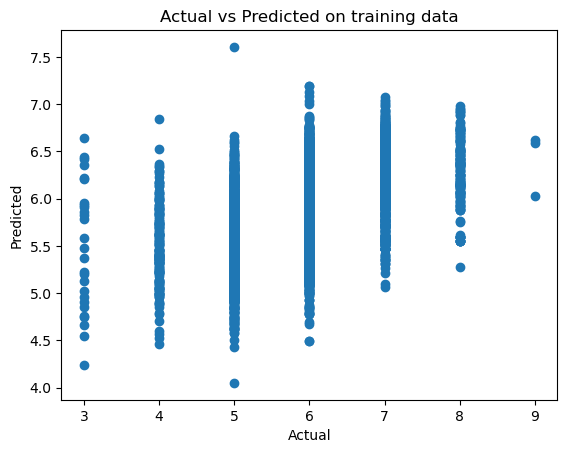

In [224]:
import matplotlib.pyplot as plt

# plot the scatter of actual data and predicted data
plt.scatter(y_train, y_train_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted on training data')
plt.show()

- Interpretation: We can see that the actual target is discrete, while the predicted target is continuous and most of the prediction does not match the actual one. For every actual target, its prediction error always range from 0 to 3. Also the minimum predicted value is 4, the maximum is 7.5. So the model cannot correctly predict the target when its actual value is 3, 8 and 9. 

- That's probably because the data and target does not follow a linear relationship. So the simple LR does not work well.


#### 5. Report the MSE of train and test set.

In [225]:
# calculate the mean square error
def RMSE(y_true, y_pred):
    diff = y_true-y_pred
    square_error = diff.T @ diff
    regularized = square_error / len(y_true)
    rooted = np.sqrt(regularized)
    return rooted

In [227]:
print(f'RMSE of train set: {RMSE(y_train, y_train_pred)}')
print(f'RMSE of test set: {RMSE(y_test, y_test_pred)}')

RMSE of train set: [[0.74242331]]
RMSE of test set: [[0.69274337]]


#### 6.Implement the least-mean-squares (LMS) algorithm for linear regression with random initialization of $w(0)$ and stepsize($s$)

In [228]:
print(X.shape)
print(y.shape)

(6497, 11)
(6497, 1)


In [229]:
import numpy as np
from sklearn.preprocessing import StandardScaler

class LMSLinearRegression:
    def __init__(self, stepsize=0.01, max_iter=2000):

        self.stepsize = stepsize
        self.max_iter = max_iter
        self.beta = None
        # scales the data to 0 mean and unit variance to avoid overflow
        self.scaler = StandardScaler()  

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        X = add_one(X)
        np.random.seed(23)
        self.beta = np.random.randn(X.shape[1])
        for i in range(self.max_iter):
            predictions = X @ self.beta
            # convert the shape of y from (5197,1) to (5197,) to match with predictions
            y = y.flatten()
            error = y - predictions
            gradient = -2 * X.T @ error/ X.shape[0]
            self.beta -= self.stepsize * gradient
    
    def predict(self, X):
        X = self.scaler.transform(X)
        X = add_one(X)
        return X @ self.beta


#### 7. Report the root-mean-square on the train and test sets

In [230]:
# train the model and do predictions
model = LMSLinearRegression(stepsize=0.05, max_iter=2000)
model.fit(X_train, y_train)

y_train_pred_lms = model.predict(X_train)
y_test_pred_lms = model.predict(X_test)
y_val_pred_lms = model.predict(X_val)
# the shape of every y_pred after lms LR is (5197,)
# we need to change it to (5197,1) to fit the RMSE function
y_train_pred_lms = y_train_pred_lms.reshape(-1, 1)
y_test_pred_lms = y_test_pred_lms.reshape(-1, 1)
y_val_pred_lms = y_val_pred_lms.reshape(-1, 1)


In [231]:
'''
having the RMSE of validation set, we can further fintune our model, 
change the max_iter and stepsize to maximize its performance
'''
print(f'RMSE of validation set: {RMSE(y_val, y_val_pred_lms)}')



RMSE of validation set: [[0.71572562]]


RMSE of validation set: 
| stepsize | max_iteration |   RMSE    |
|----------|---------------|-----------|
|   0.01   |     1000      | 0.72622828|
|   0.02   |     1000      | 0.71904971|
|   0.05   |     1000      | 0.71589669|
|   0.05   |     2000      | 0.71572562|
|   0.05   |     3000      | 0.71572097|

Thus we choose stepsize=0.05, max_iteration=2000 as the hyperparameter. 

In [232]:
print(f'RMSE of train set: {RMSE(y_train, y_train_pred_lms)}')
print(f'RMSE of test set: {RMSE(y_test, y_test_pred_lms)}')


RMSE of train set: [[0.74242336]]
RMSE of test set: [[0.69274179]]


We can see that it has similar performance with the closed form solution.